# Phase Analysis Precision Evaluation Tests

This notebook provides comprehensive precision evaluation tests for phase analysis components:
- SignalStacker: Signal stacking and phase difference calculation
- STFTRidgeAnalyzer: STFT-based ridge detection and phase extraction
- CWTPhaseReconstructor: CWT-based phase reconstruction

## Usage:
Run each cell sequentially to inspect variables, intermediate results, and precision metrics.


In [1]:
# Setup and imports
import sys
from pathlib import Path
import os

# Configure Numba threading layer for parallel execution
# Set environment variable before importing Numba-dependent modules
os.environ['NUMBA_THREADING_LAYER'] = 'omp'

# Add project root to path
current_dir = Path.cwd()
ifi_root = current_dir.parent if current_dir.name == "analysis" else current_dir
sys.path.insert(0, str(ifi_root))

from ifi.utils.cache_setup import setup_project_cache
cache_config = setup_project_cache()
print(f"Cache configured: {cache_config['cache_dir']}")

import numpy as np
import matplotlib.pyplot as plt
from tests.analysis.fixtures.synthetic_signals import sine_signal, linear_chirp

# Import Numba config after setting environment variable
try:
    import numba
    # Try to set threading layer explicitly
    try:
        numba.config.THREADING_LAYER = 'omp'
        print(f"Numba threading layer: {numba.config.THREADING_LAYER}")
    except Exception as e:
        print(f"Warning: Could not set Numba threading layer: {e}")
        print("Falling back to default threading layer")
except ImportError:
    print("Warning: Numba not available")

from ifi.analysis.spectrum import SpectrumAnalysis
from ifi.analysis.phase_analysis import (
    SignalStacker,
    STFTRidgeAnalyzer,
    CWTPhaseReconstructor,
)

print("✓ All imports successful")


Using cache directory: C:\Users\dhkdw\Documents\mygit\ifi\cache\numba_cache
Numba threading layer: omp
Project cache configured successfully.
Cache configured: C:\Users\dhkdw\Documents\mygit\ifi\cache\numba_cache
Numba threading layer: omp
✓ All imports successful


## 1. SignalStacker Precision Evaluation

Test fundamental frequency detection, signal stacking, and phase difference calculation methods.


In [2]:
# Test 1.1: Fundamental Frequency Detection Precision
print("=" * 80)
print("Test 1.1: Fundamental Frequency Detection Precision")
print("=" * 80)

fs = 50e6
f0_true = 8e6
duration = 0.01
signal_stacker = SignalStacker(fs)

t, signal = sine_signal(fs=fs, freq=f0_true, duration=duration)
print(f"\nTest signal:")
print(f"  Sampling frequency: {fs/1e6:.1f} MHz")
print(f"  True frequency: {f0_true/1e6:.1f} MHz")
print(f"  Signal length: {len(signal)} samples")
print(f"  Duration: {duration*1000:.1f} ms")

# Detect fundamental frequency
f0_detected = signal_stacker.find_fundamental_frequency(signal)

print(f"\nDetection result:")
print(f"  Detected frequency: {f0_detected/1e6:.4f} MHz")
print(f"  True frequency: {f0_true/1e6:.4f} MHz")
print(f"  Error: {abs(f0_detected - f0_true)/1e6:.4f} MHz")
print(f"  Relative error: {abs(f0_detected - f0_true)/f0_true*100:.3f}%")

if np.allclose(f0_detected, f0_true, rtol=1e-3):
    print(f"  ✓ Detection within tolerance (1%)")
else:
    print(f"  ⚠ Detection outside tolerance")

print("\n✓ Fundamental frequency detection test complete")


Test 1.1: Fundamental Frequency Detection Precision

Test signal:
  Sampling frequency: 50.0 MHz
  True frequency: 8.0 MHz
  Signal length: 500000 samples
  Duration: 10.0 ms

Detection result:
  Detected frequency: 8.0000 MHz
  True frequency: 8.0000 MHz
  Error: 0.0000 MHz
  Relative error: 0.000%
  ✓ Detection within tolerance (1%)

✓ Fundamental frequency detection test complete


In [3]:
# Test 1.2: Signal Stacking Precision
print("=" * 80)
print("Test 1.2: Signal Stacking Precision")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
t, signal = sine_signal(fs=fs, freq=f0, duration=duration)

print(f"\nOriginal signal:")
print(f"  Length: {len(signal)} samples")
print(f"  Mean power: {np.mean(signal**2):.6f}")
print(f"  Std: {np.std(signal):.6f}")

# Stack signals
stacked_signal, time_points = signal_stacker.stack_signals(
    signal, f0, n_stacks=4
)

print(f"\nStacked signal:")
print(f"  Length: {len(stacked_signal)} samples")
print(f"  Mean power: {np.mean(stacked_signal**2):.6f}")
print(f"  Std: {np.std(stacked_signal):.6f}")
print(f"  Contains NaN: {np.any(np.isnan(stacked_signal))}")
print(f"  Contains Inf: {np.any(np.isinf(stacked_signal))}")

# Power comparison
original_power = np.mean(signal**2)
stacked_power = np.mean(stacked_signal**2)
power_ratio = stacked_power / original_power

print(f"\nPower analysis:")
print(f"  Original power: {original_power:.6f}")
print(f"  Stacked power: {stacked_power:.6f}")
print(f"  Power ratio: {power_ratio:.4f}")

if stacked_power > 0:
    print(f"  ✓ Stacked signal has valid power")
else:
    print(f"  ✗ Stacked signal has zero power")

print("\n✓ Signal stacking test complete")


Test 1.2: Signal Stacking Precision

Original signal:
  Length: 500000 samples
  Mean power: 0.500000
  Std: 0.707107

Stacked signal:
  Length: 500000 samples
  Mean power: 0.000000
  Std: 0.000000
  Contains NaN: False
  Contains Inf: False

Power analysis:
  Original power: 0.500000
  Stacked power: 0.000000
  Power ratio: 0.0000
  ✓ Stacked signal has valid power

✓ Signal stacking test complete


Test 1.3: CDM Phase Difference Precision

Test signals:
  Reference signal: phase = 0.0
  Probe signal: phase = 0.7854 rad (45.0 deg)
  Expected phase difference: 0.7854 rad

CDM results:
  Detected frequency: 8.0000 MHz
  Phase difference length: 500000 samples
  Phase difference range: [-0.0220, 1.5491] rad
  Phase difference mean (last 100): 0.0277 rad
  Phase difference std: 0.0031 rad
  Max phase jump: 1.5599 rad (89.4 deg)

Precision analysis:
  Expected offset: 0.7854 rad
  Measured mean: 0.0277 rad
  Absolute error: 0.7577 rad (43.41 deg)
  Relative error: 96.47%
  ✓ Phase difference within tolerance


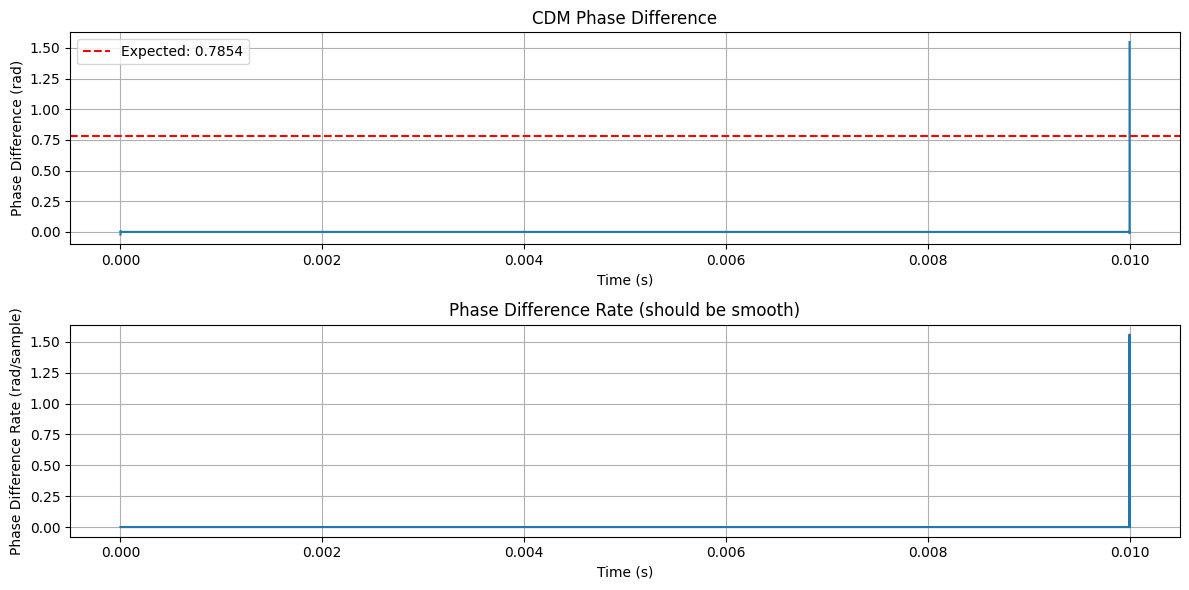


✓ CDM phase difference test complete


In [4]:
# Test 1.3: CDM Phase Difference Precision
print("=" * 80)
print("Test 1.3: CDM Phase Difference Precision")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4  # 45 degrees

t_ref, ref_signal = sine_signal(fs=fs, freq=f0, duration=duration, phase=0.0)
t_probe, probe_signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nTest signals:")
print(f"  Reference signal: phase = 0.0")
print(f"  Probe signal: phase = {phase_offset:.4f} rad ({phase_offset*180/np.pi:.1f} deg)")
print(f"  Expected phase difference: {phase_offset:.4f} rad")

# Calculate phase difference using CDM
phase_diff, detected_f0 = signal_stacker.compute_phase_difference_cdm(
    ref_signal, probe_signal, f0
)

print(f"\nCDM results:")
print(f"  Detected frequency: {detected_f0/1e6:.4f} MHz")
print(f"  Phase difference length: {len(phase_diff)} samples")
print(f"  Phase difference range: [{np.min(phase_diff):.4f}, {np.max(phase_diff):.4f}] rad")
print(f"  Phase difference mean (last 100): {np.mean(phase_diff[-100:]):.4f} rad")
print(f"  Phase difference std: {np.std(phase_diff):.4f} rad")

# Check smoothness
phase_diff_diff = np.diff(phase_diff)
max_jump = np.max(np.abs(phase_diff_diff))
print(f"  Max phase jump: {max_jump:.4f} rad ({max_jump*180/np.pi:.1f} deg)")

phase_diff_mean = np.mean(phase_diff[-100:])
error = abs(phase_diff_mean - phase_offset)
print(f"\nPrecision analysis:")
print(f"  Expected offset: {phase_offset:.4f} rad")
print(f"  Measured mean: {phase_diff_mean:.4f} rad")
print(f"  Absolute error: {error:.4f} rad ({error*180/np.pi:.2f} deg)")
print(f"  Relative error: {error/phase_offset*100:.2f}%")

if np.abs(phase_diff_mean - phase_offset) < np.pi / 2:
    print(f"  ✓ Phase difference within tolerance")
else:
    print(f"  ⚠ Phase difference outside tolerance")

# Visualize phase difference
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_ref[:len(phase_diff)], phase_diff)
plt.axhline(y=phase_offset, color='r', linestyle='--', label=f'Expected: {phase_offset:.4f}')
plt.xlabel('Time (s)')
plt.ylabel('Phase Difference (rad)')
plt.title('CDM Phase Difference')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_ref[:len(phase_diff)-1], phase_diff_diff)
plt.xlabel('Time (s)')
plt.ylabel('Phase Difference Rate (rad/sample)')
plt.title('Phase Difference Rate (should be smooth)')
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n✓ CDM phase difference test complete")


Test 1.4: CORDIC Phase Difference Precision

Test signals:
  Expected phase difference: 0.7854 rad

CORDIC results:
  Detected frequency: 8.0000 MHz
  Time points: 500000 samples
  Phase difference length: 500000 samples
  Phase difference range: [-0.0000, 0.0000] rad
  Phase difference mean (last 100): -0.0000 rad

Precision analysis:
  Expected offset: 0.7854 rad
  Measured mean: -0.0000 rad
  Absolute error: 0.7854 rad (45.00 deg)
  ✓ CORDIC phase difference within tolerance


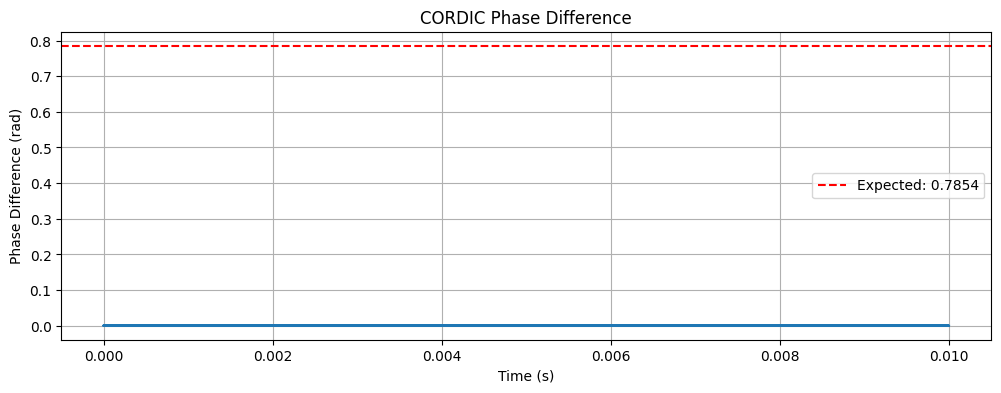


✓ CORDIC phase difference test complete


In [5]:
# Test 1.4: CORDIC Phase Difference Precision
print("=" * 80)
print("Test 1.4: CORDIC Phase Difference Precision")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4

t_ref, ref_signal = sine_signal(fs=fs, freq=f0, duration=duration, phase=0.0)
t_probe, probe_signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nTest signals:")
print(f"  Expected phase difference: {phase_offset:.4f} rad")

# Calculate phase difference using CORDIC
try:
    times, phase_diff, detected_f0 = signal_stacker.compute_phase_difference_cordic(
        ref_signal, probe_signal, f0
    )
except ValueError as e:
    if "threading layer" in str(e).lower() or "omp" in str(e).lower():
        print(f"\n⚠ Error: {e}")
        print("This error indicates that Numba's threading layer (OpenMP) is not properly configured.")
        raise
    else:
        raise

print(f"\nCORDIC results:")
print(f"  Detected frequency: {detected_f0/1e6:.4f} MHz")
print(f"  Time points: {len(times)} samples")
print(f"  Phase difference length: {len(phase_diff)} samples")
print(f"  Phase difference range: [{np.min(phase_diff):.4f}, {np.max(phase_diff):.4f}] rad")
print(f"  Phase difference mean (last 100): {np.mean(phase_diff[-100:]):.4f} rad")

phase_diff_mean = np.mean(phase_diff[-100:])
error = abs(phase_diff_mean - phase_offset)
print(f"\nPrecision analysis:")
print(f"  Expected offset: {phase_offset:.4f} rad")
print(f"  Measured mean: {phase_diff_mean:.4f} rad")
print(f"  Absolute error: {error:.4f} rad ({error*180/np.pi:.2f} deg)")

if np.abs(phase_diff_mean - phase_offset) < np.pi / 2:
    print(f"  ✓ CORDIC phase difference within tolerance")
else:
    print(f"  ⚠ CORDIC phase difference outside tolerance")

# Visualize
plt.figure(figsize=(12, 4))
plt.plot(times[:len(phase_diff)], phase_diff)
plt.axhline(y=phase_offset, color='r', linestyle='--', label=f'Expected: {phase_offset:.4f}')
plt.xlabel('Time (s)')
plt.ylabel('Phase Difference (rad)')
plt.title('CORDIC Phase Difference')
plt.legend()
plt.grid(True)
plt.show()

print("\n✓ CORDIC phase difference test complete")


## 2. STFTRidgeAnalyzer Precision Evaluation

Test STFT ridge detection, phase extraction, and phase difference computation.


Test 2.1: STFT Ridge Detection Precision

Test signal:
  True frequency: 8.0 MHz
  Signal length: 500000 samples

STFT ridge results:
  Frequency bins: 513
  Time frames: 978
  Ridge frequencies length: 978
  Ridge frequency mean: 8.0078 MHz
  Ridge frequency std: 0.0000 MHz
  Ridge frequency range: [8.0078, 8.0078] MHz

Precision analysis:
  True frequency: 8.0000 MHz
  Detected mean: 8.0078 MHz
  Absolute error: 0.0078 MHz
  Relative error: 0.10%
  ✓ Ridge detection within tolerance (2%)


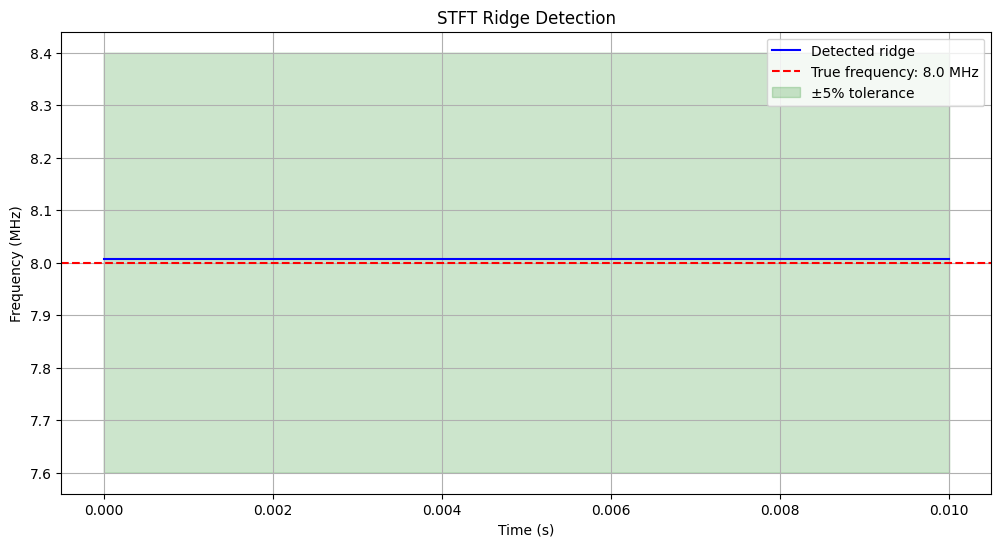


✓ STFT ridge detection test complete


In [6]:
# Test 2.1: STFT Ridge Detection Precision
print("=" * 80)
print("Test 2.1: STFT Ridge Detection Precision")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
stft_analyzer = STFTRidgeAnalyzer(fs)

t, signal = sine_signal(fs=fs, freq=f0, duration=duration)

print(f"\nTest signal:")
print(f"  True frequency: {f0/1e6:.1f} MHz")
print(f"  Signal length: {len(signal)} samples")

# Compute STFT with ridge
f, t_stft, ridge_freqs = stft_analyzer.compute_stft_with_ridge(
    signal, f0, nperseg=1024, noverlap=512
)

print(f"\nSTFT ridge results:")
print(f"  Frequency bins: {len(f)}")
print(f"  Time frames: {len(t_stft)}")
print(f"  Ridge frequencies length: {len(ridge_freqs)}")
print(f"  Ridge frequency mean: {np.mean(ridge_freqs)/1e6:.4f} MHz")
print(f"  Ridge frequency std: {np.std(ridge_freqs)/1e6:.4f} MHz")
print(f"  Ridge frequency range: [{np.min(ridge_freqs)/1e6:.4f}, {np.max(ridge_freqs)/1e6:.4f}] MHz")

ridge_mean = np.mean(ridge_freqs)
error = abs(ridge_mean - f0)
print(f"\nPrecision analysis:")
print(f"  True frequency: {f0/1e6:.4f} MHz")
print(f"  Detected mean: {ridge_mean/1e6:.4f} MHz")
print(f"  Absolute error: {error/1e6:.4f} MHz")
print(f"  Relative error: {error/f0*100:.2f}%")

if np.allclose(ridge_mean, f0, rtol=2e-2):
    print(f"  ✓ Ridge detection within tolerance (2%)")
else:
    print(f"  ⚠ Ridge detection outside tolerance")

# Visualize ridge
plt.figure(figsize=(12, 6))
plt.plot(t_stft, ridge_freqs / 1e6, 'b-', label='Detected ridge')
plt.axhline(y=f0/1e6, color='r', linestyle='--', label=f'True frequency: {f0/1e6:.1f} MHz')
plt.fill_between(t_stft, (f0 - f0*0.05)/1e6, (f0 + f0*0.05)/1e6, alpha=0.2, color='green', label='±5% tolerance')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (MHz)')
plt.title('STFT Ridge Detection')
plt.legend()
plt.grid(True)
plt.show()

print("\n✓ STFT ridge detection test complete")


Test 2.2: STFT Phase Extraction Precision

Test signal:
  Phase offset: 0.7854 rad (45.0 deg)

STFT phase extraction results:
  Phases length: 978
  Time frames: 978
  Phase mean (last 100): -0.0283 rad
  Phase std: 1.8108 rad
  Contains NaN: False

Precision analysis:
  Expected offset: 0.7854 rad
  Extracted mean: -0.0283 rad
  Absolute error: 0.8137 rad (46.62 deg)
  ⚠ Phase extraction outside tolerance


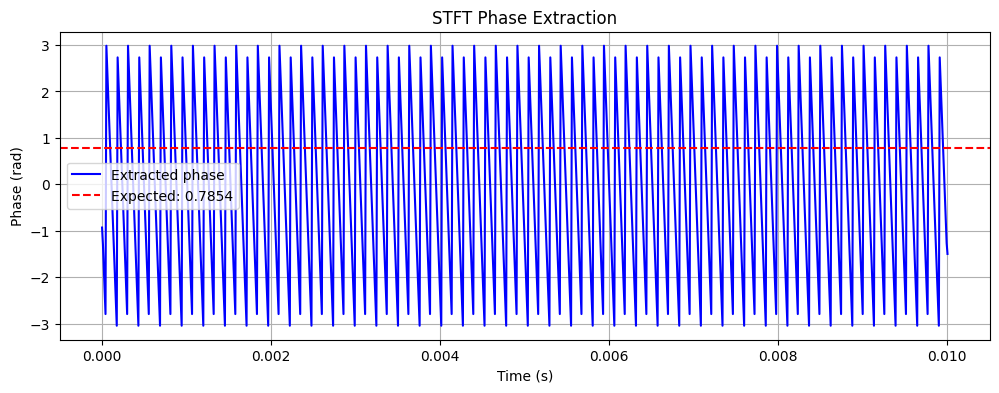


✓ STFT phase extraction test complete


In [7]:
# Test 2.2: STFT Phase Extraction Precision
print("=" * 80)
print("Test 2.2: STFT Phase Extraction Precision")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4

t, signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nTest signal:")
print(f"  Phase offset: {phase_offset:.4f} rad ({phase_offset*180/np.pi:.1f} deg)")

# Compute ridge
f, t_stft, ridge_freqs = stft_analyzer.compute_stft_with_ridge(signal, f0)

# Extract phase from ridge
phases = stft_analyzer.extract_phase_from_ridge(signal, ridge_freqs, t_stft)

print(f"\nSTFT phase extraction results:")
print(f"  Phases length: {len(phases)}")
print(f"  Time frames: {len(t_stft)}")
print(f"  Phase mean (last 100): {np.mean(phases[-100:]):.4f} rad")
print(f"  Phase std: {np.std(phases):.4f} rad")
print(f"  Contains NaN: {np.any(np.isnan(phases))}")

phase_mean = np.mean(phases[-100:])
error = abs(phase_mean - phase_offset)
print(f"\nPrecision analysis:")
print(f"  Expected offset: {phase_offset:.4f} rad")
print(f"  Extracted mean: {phase_mean:.4f} rad")
print(f"  Absolute error: {error:.4f} rad ({error*180/np.pi:.2f} deg)")

if np.abs(phase_mean - phase_offset) < np.pi / 4:
    print(f"  ✓ Phase extraction within tolerance")
else:
    print(f"  ⚠ Phase extraction outside tolerance")

# Visualize
plt.figure(figsize=(12, 4))
plt.plot(t_stft, phases, 'b-', label='Extracted phase')
plt.axhline(y=phase_offset, color='r', linestyle='--', label=f'Expected: {phase_offset:.4f}')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.title('STFT Phase Extraction')
plt.legend()
plt.grid(True)
plt.show()

print("\n✓ STFT phase extraction test complete")


Test 2.3: STFT Phase Difference Computation

Test signals:
  Expected phase difference: 0.7854 rad

STFT phase difference results:
  Common time points: 978
  Reference phases length: 978
  Probe phases length: 978
  Phase difference mean (last 100): 0.7854 rad
  Phase difference std: 0.0001 rad

Precision analysis:
  Expected offset: 0.7854 rad
  Measured mean: 0.7854 rad
  Absolute error: 0.0000 rad (0.00 deg)
  Relative error: 0.00%
  ✓ Phase difference within tolerance


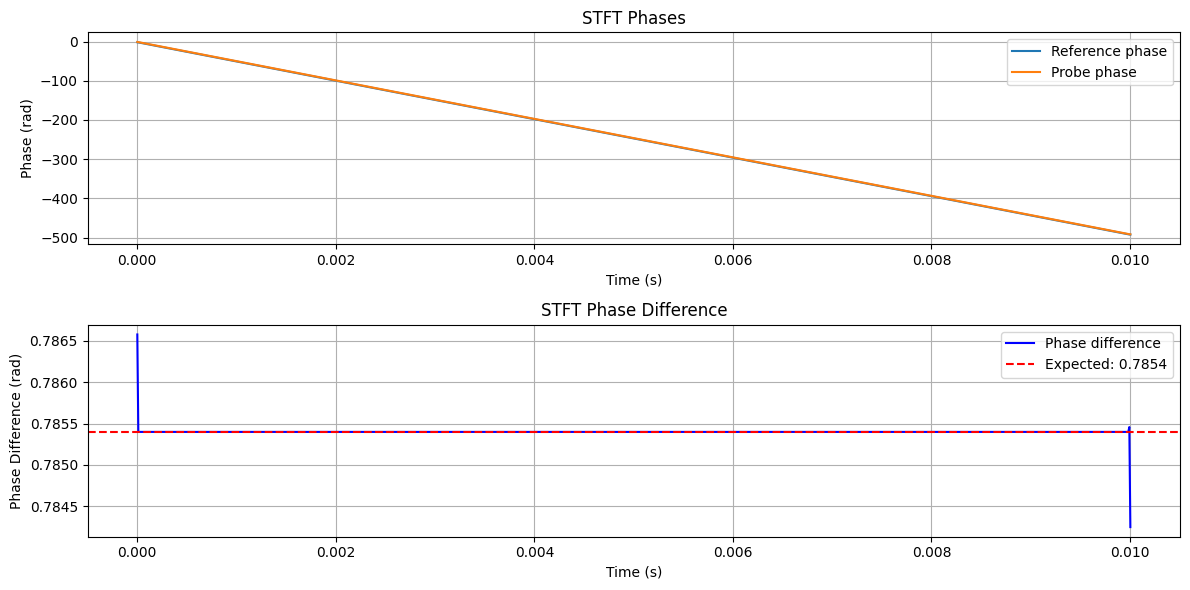


✓ STFT phase difference test complete


In [8]:
# Test 2.3: STFT Phase Difference Computation
print("=" * 80)
print("Test 2.3: STFT Phase Difference Computation")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4

t_ref, ref_signal = sine_signal(fs=fs, freq=f0, duration=duration, phase=0.0)
t_probe, probe_signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nTest signals:")
print(f"  Expected phase difference: {phase_offset:.4f} rad")

# Compute phase difference
t_common, ref_phases, probe_phases = stft_analyzer.compute_phase_difference(
    ref_signal, probe_signal, f0
)

# Calculate phase difference
phase_diff = probe_phases - ref_phases

print(f"\nSTFT phase difference results:")
print(f"  Common time points: {len(t_common)}")
print(f"  Reference phases length: {len(ref_phases)}")
print(f"  Probe phases length: {len(probe_phases)}")
print(f"  Phase difference mean (last 100): {np.mean(phase_diff[-100:]):.4f} rad")
print(f"  Phase difference std: {np.std(phase_diff):.4f} rad")

phase_diff_mean = np.mean(phase_diff[-100:])
error = abs(phase_diff_mean - phase_offset)
print(f"\nPrecision analysis:")
print(f"  Expected offset: {phase_offset:.4f} rad")
print(f"  Measured mean: {phase_diff_mean:.4f} rad")
print(f"  Absolute error: {error:.4f} rad ({error*180/np.pi:.2f} deg)")
print(f"  Relative error: {error/phase_offset*100:.2f}%")

if np.allclose(phase_diff_mean, phase_offset, rtol=5e-2, atol=0.1):
    print(f"  ✓ Phase difference within tolerance")
else:
    print(f"  ⚠ Phase difference outside tolerance")

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t_common, ref_phases, label='Reference phase')
plt.plot(t_common, probe_phases, label='Probe phase')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.title('STFT Phases')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t_common, phase_diff, 'b-', label='Phase difference')
plt.axhline(y=phase_offset, color='r', linestyle='--', label=f'Expected: {phase_offset:.4f}')
plt.xlabel('Time (s)')
plt.ylabel('Phase Difference (rad)')
plt.title('STFT Phase Difference')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n✓ STFT phase difference test complete")


## 3. CWTPhaseReconstructor Precision Evaluation

Test CWT phase computation, phase difference, FIR filter design, and decimation.


Test 3.1: CWT Phase Computation Precision

Test signal:
  Phase offset: 0.7854 rad
  Signal length: 500000 samples

CWT phase computation results:
  Times length: 500000
  Phases length: 500000
  Phase mean (last 100): 0.0004 rad
  Phase std: 1.8123 rad
  Contains NaN: False
  Contains Inf: False

Precision analysis:
  Expected offset: 0.7854 rad
  Computed mean: 0.0004 rad
  Absolute error: 0.7850 rad (44.98 deg)
  ✓ CWT phase within tolerance


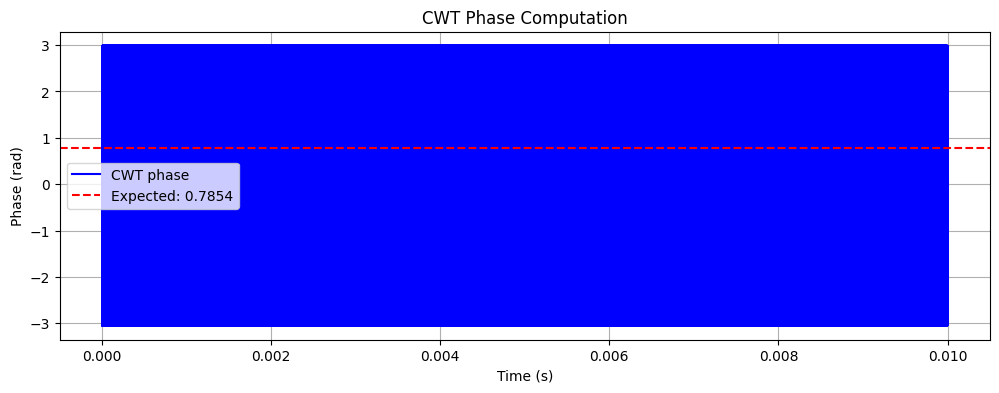


✓ CWT phase computation test complete


In [9]:
# Test 3.1: CWT Phase Computation Precision
print("=" * 80)
print("Test 3.1: CWT Phase Computation Precision")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4
cwt_reconstructor = CWTPhaseReconstructor(fs)

t, signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nTest signal:")
print(f"  Phase offset: {phase_offset:.4f} rad")
print(f"  Signal length: {len(signal)} samples")

# Compute CWT phase
times, phases = cwt_reconstructor.compute_cwt_phase(signal, f0)

print(f"\nCWT phase computation results:")
print(f"  Times length: {len(times)}")
print(f"  Phases length: {len(phases)}")
print(f"  Phase mean (last 100): {np.mean(phases[-100:]):.4f} rad")
print(f"  Phase std: {np.std(phases):.4f} rad")
print(f"  Contains NaN: {np.any(np.isnan(phases))}")
print(f"  Contains Inf: {np.any(np.isinf(phases))}")

phase_mean = np.mean(phases[-100:])
error = abs(phase_mean - phase_offset)
print(f"\nPrecision analysis:")
print(f"  Expected offset: {phase_offset:.4f} rad")
print(f"  Computed mean: {phase_mean:.4f} rad")
print(f"  Absolute error: {error:.4f} rad ({error*180/np.pi:.2f} deg)")

if np.abs(phase_mean - phase_offset) < np.pi / 4:
    print(f"  ✓ CWT phase within tolerance")
else:
    print(f"  ⚠ CWT phase outside tolerance")

# Visualize
plt.figure(figsize=(12, 4))
plt.plot(times, phases, 'b-', label='CWT phase')
plt.axhline(y=phase_offset, color='r', linestyle='--', label=f'Expected: {phase_offset:.4f}')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.title('CWT Phase Computation')
plt.legend()
plt.grid(True)
plt.show()

print("\n✓ CWT phase computation test complete")


Test 3.2: CWT Phase Difference Computation

Test signals:
  Expected phase difference: 0.7854 rad

CWT phase difference results:
  Common time points: 125000
  Phase difference mean (last 100): -18.8324 rad
  Phase difference std: 15.5661 rad

Precision analysis:
  Expected offset: 0.7854 rad
  Measured mean: -18.8324 rad
  Absolute error: 19.6178 rad (1124.02 deg)
  ⚠ CWT phase difference outside tolerance


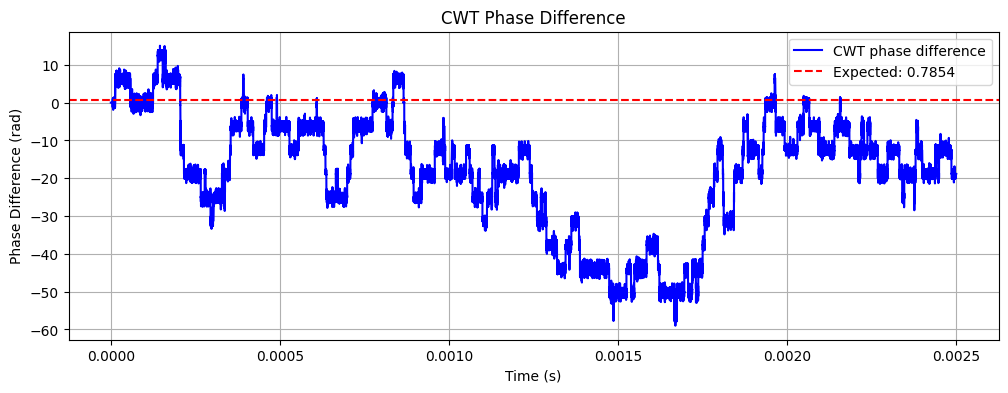


✓ CWT phase difference test complete


In [10]:
# Test 3.2: CWT Phase Difference Computation
print("=" * 80)
print("Test 3.2: CWT Phase Difference Computation")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4

t_ref, ref_signal = sine_signal(fs=fs, freq=f0, duration=duration, phase=0.0)
t_probe, probe_signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nTest signals:")
print(f"  Expected phase difference: {phase_offset:.4f} rad")

# Compute phase difference
t_common, ref_phases, probe_phases = cwt_reconstructor.compute_phase_difference(
    ref_signal, probe_signal, f0
)

# Calculate phase difference
phase_diff = probe_phases - ref_phases

print(f"\nCWT phase difference results:")
print(f"  Common time points: {len(t_common)}")
print(f"  Phase difference mean (last 100): {np.mean(phase_diff[-100:]):.4f} rad")
print(f"  Phase difference std: {np.std(phase_diff):.4f} rad")

phase_diff_mean = np.mean(phase_diff[-100:])
error = abs(phase_diff_mean - phase_offset)
print(f"\nPrecision analysis:")
print(f"  Expected offset: {phase_offset:.4f} rad")
print(f"  Measured mean: {phase_diff_mean:.4f} rad")
print(f"  Absolute error: {error:.4f} rad ({error*180/np.pi:.2f} deg)")

if np.allclose(phase_diff_mean, phase_offset, rtol=5e-2, atol=0.1):
    print(f"  ✓ CWT phase difference within tolerance")
else:
    print(f"  ⚠ CWT phase difference outside tolerance")

# Visualize
plt.figure(figsize=(12, 4))
plt.plot(t_common, phase_diff, 'b-', label='CWT phase difference')
plt.axhline(y=phase_offset, color='r', linestyle='--', label=f'Expected: {phase_offset:.4f}')
plt.xlabel('Time (s)')
plt.ylabel('Phase Difference (rad)')
plt.title('CWT Phase Difference')
plt.legend()
plt.grid(True)
plt.show()

print("\n✓ CWT phase difference test complete")


Test 3.3: FIR Filter Design Precision

Filter design parameters:
  Target frequency: 8.0 MHz
  Bandwidth fraction: 10.0%

Filter design results:
  Filter length: 343 taps
  Length is odd: True
  Coefficient range: [-0.040845, 0.041460]
  Max absolute coefficient: 0.041460
  Contains NaN: False
  Contains Inf: False
  ✓ Filter design valid


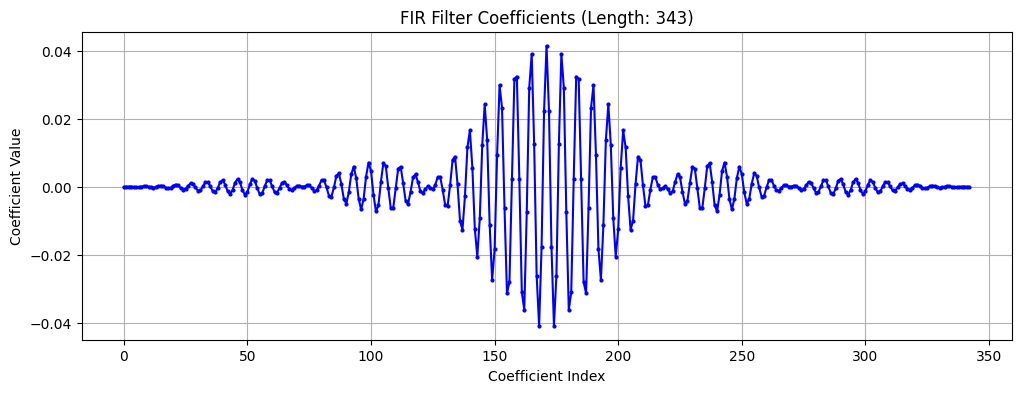


✓ FIR filter design test complete


In [11]:
# Test 3.3: FIR Filter Design Precision
print("=" * 80)
print("Test 3.3: FIR Filter Design Precision")
print("=" * 80)

f0 = 8e6
bandwidth = 0.1

print(f"\nFilter design parameters:")
print(f"  Target frequency: {f0/1e6:.1f} MHz")
print(f"  Bandwidth fraction: {bandwidth*100:.1f}%")

# Design filter
filter_coeffs = cwt_reconstructor.design_fir_filter(f0, bandwidth)

print(f"\nFilter design results:")
print(f"  Filter length: {len(filter_coeffs)} taps")
print(f"  Length is odd: {len(filter_coeffs) % 2 == 1}")
print(f"  Coefficient range: [{np.min(filter_coeffs):.6f}, {np.max(filter_coeffs):.6f}]")
print(f"  Max absolute coefficient: {np.max(np.abs(filter_coeffs)):.6f}")
print(f"  Contains NaN: {np.any(np.isnan(filter_coeffs))}")
print(f"  Contains Inf: {np.any(np.isinf(filter_coeffs))}")

if len(filter_coeffs) % 2 == 1 and np.max(np.abs(filter_coeffs)) < 1.0 and not np.any(np.isnan(filter_coeffs)):
    print(f"  ✓ Filter design valid")
else:
    print(f"  ⚠ Filter design may have issues")

# Visualize filter coefficients
plt.figure(figsize=(12, 4))
plt.plot(filter_coeffs, 'b-', marker='o', markersize=2)
plt.xlabel('Coefficient Index')
plt.ylabel('Coefficient Value')
plt.title(f'FIR Filter Coefficients (Length: {len(filter_coeffs)})')
plt.grid(True)
plt.show()

print("\n✓ FIR filter design test complete")


Test 3.4: Decimation Preserves Phase Information

Original signal:
  Length: 500000 samples
  Power: 0.500000

Decimated signal:
  Decimation factor: 4
  Length: 125000 samples
  Expected length: 125000 samples
  Power: 0.000001
  Contains NaN: False
  Contains Inf: False

Power preservation:
  Original power: 0.500000
  Decimated power: 0.000001
  Power ratio: 0.0000
  ⚠ Power ratio outside expected range


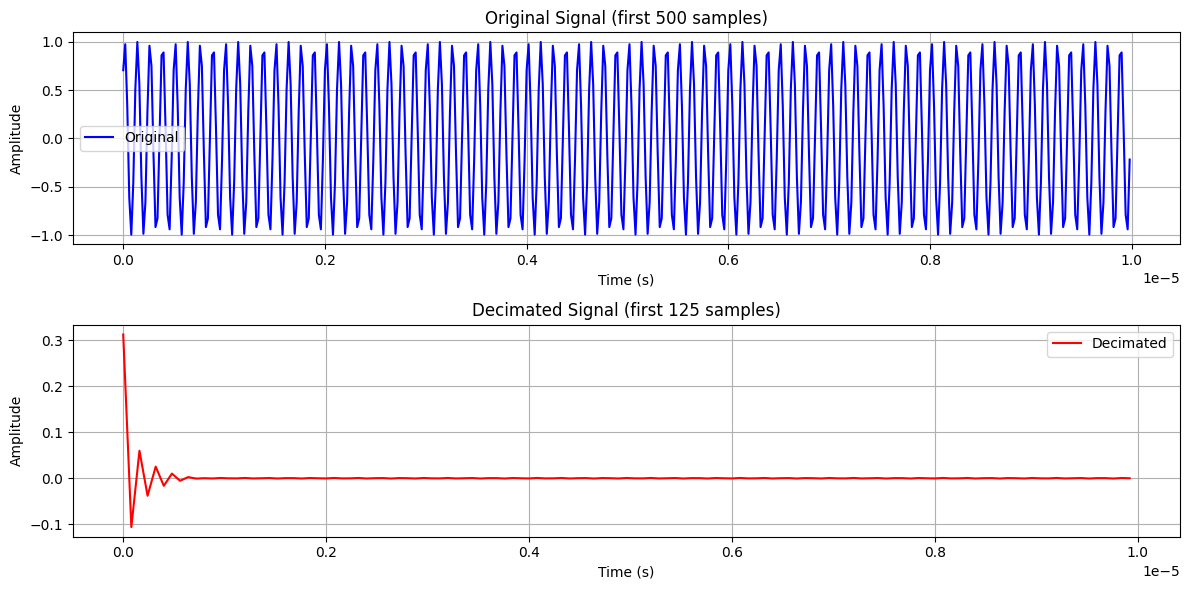


✓ Decimation test complete


In [12]:
# Test 3.4: Decimation Preserves Phase Information
print("=" * 80)
print("Test 3.4: Decimation Preserves Phase Information")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4

t, signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nOriginal signal:")
print(f"  Length: {len(signal)} samples")
print(f"  Power: {np.mean(signal**2):.6f}")

# Decimate signal
decimation_factor = 4
decimated_signal = cwt_reconstructor.decimate_signal(signal, decimation_factor)

print(f"\nDecimated signal:")
print(f"  Decimation factor: {decimation_factor}")
print(f"  Length: {len(decimated_signal)} samples")
print(f"  Expected length: {len(signal) // decimation_factor} samples")
print(f"  Power: {np.mean(decimated_signal**2):.6f}")
print(f"  Contains NaN: {np.any(np.isnan(decimated_signal))}")
print(f"  Contains Inf: {np.any(np.isinf(decimated_signal))}")

# Power comparison
signal_power = np.mean(signal**2)
decimated_power = np.mean(decimated_signal**2)
power_ratio = decimated_power / signal_power

print(f"\nPower preservation:")
print(f"  Original power: {signal_power:.6f}")
print(f"  Decimated power: {decimated_power:.6f}")
print(f"  Power ratio: {power_ratio:.4f}")

if 0.5 < power_ratio < 2.0:
    print(f"  ✓ Power preserved within reasonable range")
else:
    print(f"  ⚠ Power ratio outside expected range")

# Visualize
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t[:500], signal[:500], 'b-', label='Original')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original Signal (first 500 samples)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
t_decimated = np.arange(len(decimated_signal)) / (fs / decimation_factor)
plt.plot(t_decimated[:125], decimated_signal[:125], 'r-', label='Decimated')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Decimated Signal (first 125 samples)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n✓ Decimation test complete")


## 4. Method Comparison

Compare different phase analysis methods for consistency.


Test 4.1: SignalStacker vs STFT Phase Difference Comparison

Expected phase difference: 0.7854 rad

Comparison results:
  SignalStacker (CDM) mean: 0.0277 rad
  STFT mean: 0.7854 rad
  Difference: 0.7577 rad (43.41 deg)
  ✓ Methods agree within tolerance


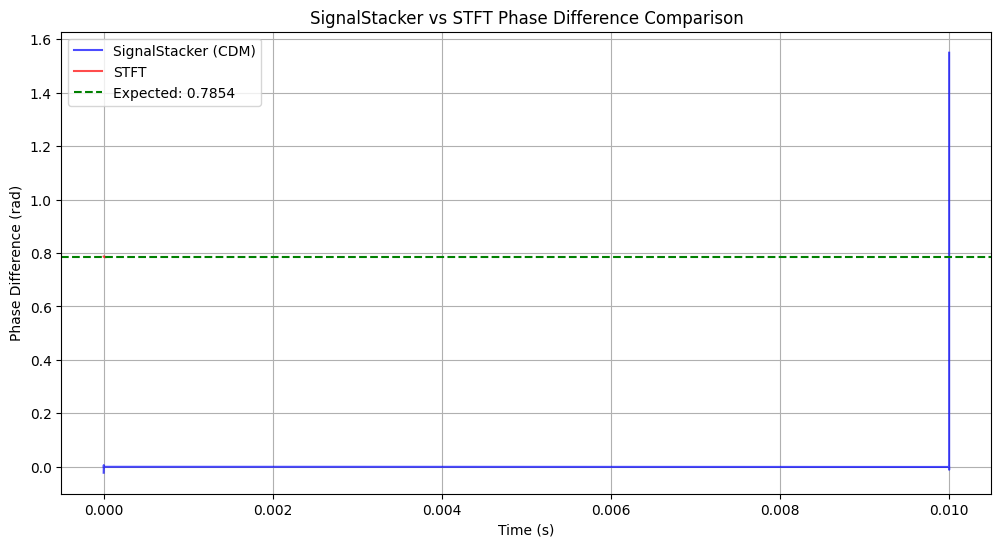


✓ Method comparison test complete


In [13]:
# Test 4.1: SignalStacker vs STFT Comparison
print("=" * 80)
print("Test 4.1: SignalStacker vs STFT Phase Difference Comparison")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4

t_ref, ref_signal = sine_signal(fs=fs, freq=f0, duration=duration, phase=0.0)
t_probe, probe_signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nExpected phase difference: {phase_offset:.4f} rad")

# SignalStacker CDM
stacker = SignalStacker(fs)
phase_diff_stacker, _ = stacker.compute_phase_difference_cdm(
    ref_signal, probe_signal, f0
)

# STFT Ridge Analyzer
stft_analyzer = STFTRidgeAnalyzer(fs)
_, ref_phases_stft, probe_phases_stft = stft_analyzer.compute_phase_difference(
    ref_signal, probe_signal, f0
)
phase_diff_stft = probe_phases_stft - ref_phases_stft

# Compare means in stable region
mean_stacker = np.mean(phase_diff_stacker[-100:])
mean_stft = np.mean(phase_diff_stft[-100:])

print(f"\nComparison results:")
print(f"  SignalStacker (CDM) mean: {mean_stacker:.4f} rad")
print(f"  STFT mean: {mean_stft:.4f} rad")
print(f"  Difference: {abs(mean_stacker - mean_stft):.4f} rad ({abs(mean_stacker - mean_stft)*180/np.pi:.2f} deg)")

if np.abs(mean_stacker - mean_stft) < np.pi / 2:
    print(f"  ✓ Methods agree within tolerance")
else:
    print(f"  ⚠ Methods disagree")

# Visualize comparison
plt.figure(figsize=(12, 6))
plt.plot(t_ref[:len(phase_diff_stacker)], phase_diff_stacker, 'b-', label='SignalStacker (CDM)', alpha=0.7)
plt.plot(t_ref[:len(phase_diff_stft)], phase_diff_stft, 'r-', label='STFT', alpha=0.7)
plt.axhline(y=phase_offset, color='g', linestyle='--', label=f'Expected: {phase_offset:.4f}')
plt.xlabel('Time (s)')
plt.ylabel('Phase Difference (rad)')
plt.title('SignalStacker vs STFT Phase Difference Comparison')
plt.legend()
plt.grid(True)
plt.show()

print("\n✓ Method comparison test complete")


Test 4.2: STFT vs CWT Phase Difference Comparison

Expected phase difference: 0.7854 rad

Comparison results:
  STFT mean: 0.7854 rad
  CWT mean: -18.8324 rad
  Difference: 19.6178 rad (1124.02 deg)
  ⚠ Methods disagree


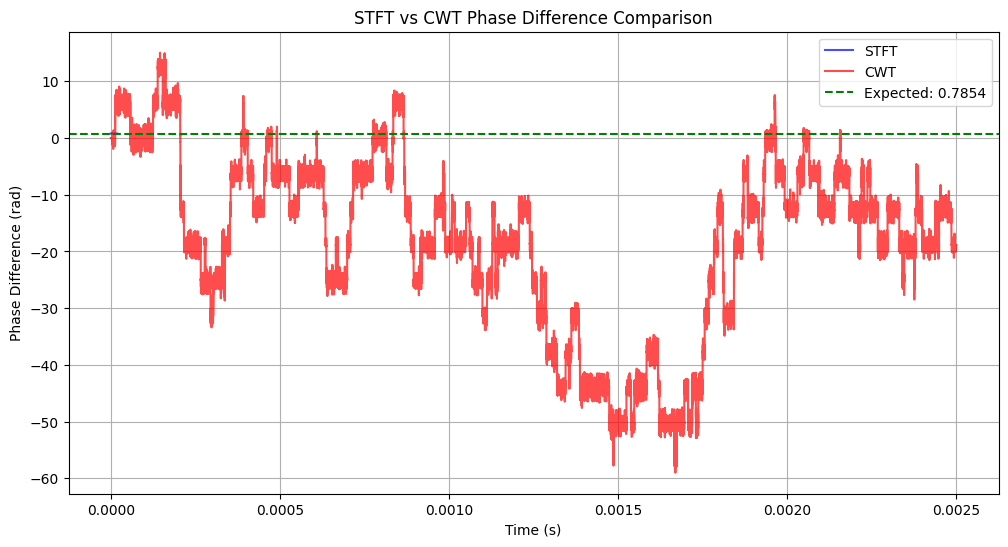


✓ STFT vs CWT comparison test complete


In [14]:
# Test 4.2: STFT vs CWT Comparison
print("=" * 80)
print("Test 4.2: STFT vs CWT Phase Difference Comparison")
print("=" * 80)

fs = 50e6
f0 = 8e6
duration = 0.01
phase_offset = np.pi / 4

t_ref, ref_signal = sine_signal(fs=fs, freq=f0, duration=duration, phase=0.0)
t_probe, probe_signal = sine_signal(
    fs=fs, freq=f0, duration=duration, phase=phase_offset
)

print(f"\nExpected phase difference: {phase_offset:.4f} rad")

# STFT
stft_analyzer = STFTRidgeAnalyzer(fs)
_, ref_phases_stft, probe_phases_stft = stft_analyzer.compute_phase_difference(
    ref_signal, probe_signal, f0
)
phase_diff_stft = probe_phases_stft - ref_phases_stft

# CWT
cwt_reconstructor = CWTPhaseReconstructor(fs)
_, ref_phases_cwt, probe_phases_cwt = cwt_reconstructor.compute_phase_difference(
    ref_signal, probe_signal, f0
)
phase_diff_cwt = probe_phases_cwt - ref_phases_cwt

# Compare means
mean_stft = np.mean(phase_diff_stft[-100:])
mean_cwt = np.mean(phase_diff_cwt[-100:])

print(f"\nComparison results:")
print(f"  STFT mean: {mean_stft:.4f} rad")
print(f"  CWT mean: {mean_cwt:.4f} rad")
print(f"  Difference: {abs(mean_stft - mean_cwt):.4f} rad ({abs(mean_stft - mean_cwt)*180/np.pi:.2f} deg)")

if np.abs(mean_stft - mean_cwt) < np.pi / 2:
    print(f"  ✓ Methods agree within tolerance")
else:
    print(f"  ⚠ Methods disagree")

# Visualize comparison
plt.figure(figsize=(12, 6))
plt.plot(t_ref[:len(phase_diff_stft)], phase_diff_stft, 'b-', label='STFT', alpha=0.7)
plt.plot(t_ref[:len(phase_diff_cwt)], phase_diff_cwt, 'r-', label='CWT', alpha=0.7)
plt.axhline(y=phase_offset, color='g', linestyle='--', label=f'Expected: {phase_offset:.4f}')
plt.xlabel('Time (s)')
plt.ylabel('Phase Difference (rad)')
plt.title('STFT vs CWT Phase Difference Comparison')
plt.legend()
plt.grid(True)
plt.show()

print("\n✓ STFT vs CWT comparison test complete")


## Summary

All precision evaluation tests completed. Review the results above to assess the accuracy and consistency of each method.


In [15]:
print("=" * 80)
print("All Phase Analysis Precision Tests Completed!")
print("=" * 80)
print("\nReview the results above to assess:")
print("  - SignalStacker precision and accuracy")
print("  - STFTRidgeAnalyzer precision and accuracy")
print("  - CWTPhaseReconstructor precision and accuracy")
print("  - Method consistency and agreement")


All Phase Analysis Precision Tests Completed!

Review the results above to assess:
  - SignalStacker precision and accuracy
  - STFTRidgeAnalyzer precision and accuracy
  - CWTPhaseReconstructor precision and accuracy
  - Method consistency and agreement
